# Genetic algorithm

- In this juptyer notebook, we apply `Genetic Algorithm` on fitting Neural Network model instead of using *gradient descent* to fit the model.
    
    + Each model is represented by a fixed-length list of parameters.

    + A population of neural network models are initlized without further training.

    + *Crossover* is performed as usual by swapping paramters between 2 models.

    + *Mutation*, however, since it is string of float numbers (not bits) we can not do flipping as normal. Instead, we add a random noise with some probability to chosen parameter.

## Import necessary libraries and define constant

In [ ]:
import sys
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

from data import Preprocessing, FeatureExtraction

# switch to device for better training
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Used device = {DEVICE}")

# define constant which can be treated hyperparameter
MAX_FEATURES = 500
GENERATIONS = 20

POPULATION_SIZE = 10
MUTATION_RATE = 0.2
MUTATION_NOISE = 0.2

Used device = mps


## Read file csv and print out necessary informations

In [2]:
prepro = Preprocessing()
df = prepro.read_CSV()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, 0 to 3533
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 276.1+ KB


,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Preprocessing step

- Encoding the label

- Applying some basics preprocessing technique on column `text` which is the main feature:

    + **clean text**: remove unnecessary characters.

    + **text lowercase**

    + **remove punction**

    + **remove stopword**

    + **Lemmatize**

- Tf-idf vectorizing for text on column `text`

- Scale dataset to standard normal distribution using `StandardScaler` 

In [3]:
# convert column `sentiment` to numerical label
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

# preprocessigng text column
df['text'] = df['text'].apply(prepro.preprocess)

# extract tf-idf vector
feature_extraction = FeatureExtraction()
tfidf_count = feature_extraction.tfidf_vectorize(df['text'], 2, max_features=MAX_FEATURES)
df_tfidf_count = tfidf_count.toarray()

# scale data to standard normal distribution
scaler = StandardScaler()
scaler.fit_transform(df_tfidf_count)

tfidf_count.shape, df_tfidf_count.shape

((3534, 500), (3534, 500))

## Split the dataset into training, validation and test set

In [4]:
X_train, X_test, y_train, y_test = feature_extraction.split_dataset(df_tfidf_count, np.array(df['label'].to_list()))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2827, 500), (707, 500), (2827,), (707,))

## Build neural model class

- We try a simple neural network model with 2 hidden layer

In [5]:
class NeuralModel(nn.Module):
    def __init__(self, input_size, hidden_layer_1=20, hidden_layer_2=10):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_layer_1)
        self.layer2 = nn.Linear(in_features=hidden_layer_1, out_features=hidden_layer_2)
        self.layer3 = nn.Linear(in_features=hidden_layer_2, out_features=3)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x

model = NeuralModel(MAX_FEATURES)
model

NeuralModel(
  (layer1): Linear(in_features=500, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (softmax): Softmax(dim=-1)
)

### Some supported functions

- `encode_weights` for flattening model into list of parameters.

- `decode_weights` for converting it back to normal neural network.

In [6]:
def encode_weights(model):
    """Flatten the weights of the model into a chromosome."""
    return torch.cat([p.view(-1) for p in model.parameters()])

def decode_weights(model, weights):
    """Reshape a chromosome into model weights."""

    with torch.no_grad():
        index = 0

        for param in model.parameters():
            num_params = param.numel()
            param.copy_(weights[index:index+num_params].view(param.shape))
            index += num_params

`initialize_population` initilizes a number of neural network and encodes their parameter into sequence of gens.

In [7]:
def initialize_population(pop_size, input_size, device="cpu", start_seed=2025):
    """
    Intialize a population of neural networks
    """
    population = []
    for i in range(pop_size):
        torch.manual_seed(start_seed+i)
        new_model = NeuralModel(input_size).to(device)
        weights = encode_weights(new_model) # convert model to sequence of gens
        population.append(weights)
    
    return population

`Fitness_score` computes the accuracy of input model

In [8]:
def fitness(weights, model, X, y, batch_size=32):
    decode_weights(model, weights)
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        device = next(model.parameters()).device  # Get model's device
        for i in range(0, len(X), batch_size):
            X_batch = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
            y_batch = torch.tensor(y[i:i+batch_size], dtype=torch.float32).to(device)

            outputs = model(X_batch).squeeze()
            pred = torch.argmax(outputs, dim=1)

            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total

# example usage
X = np.array([np.array(range(MAX_FEATURES)), np.array(range(MAX_FEATURES, MAX_FEATURES*2)), np.array(range(MAX_FEATURES*2, MAX_FEATURES*3))])
y = np.array([0,1,2])
weights = encode_weights(model)
fitness(weights, model, X, y, batch_size=3)

0.3333333333333333

`model_selection` shuffles and gets 2 models from population based on distributions generated by fitness scores.

In [9]:
def model_selection(population, fitness_score, parents_size=2):
    probabilities = fitness_score / (fitness_score.sum() + 1e-8)

    indices = torch.multinomial(probabilities, num_samples=parents_size, replacement=True)

    return [population[i] for i in indices.tolist()]

population = ['A', 'B', 'C', 'D']  # Example elements
fitness_score = torch.tensor([1.0, 2.0, 4.0, 5.0])

n = 2  # Number of elements to sample
model_selection(population, fitness_score, n)

['D', 'D']

`crossover` swaps random elements between 2 parents and returns their childrens.

In [10]:
def crossover(parent_1, parent_2, device="cpu"):
    mask = torch.randint(low=0, high=2, size=(len(parent_1),), dtype=torch.bool).to(device)
    child_1 = torch.where(mask, parent_1, parent_2)
    child_2 = torch.where(mask, parent_2, parent_1)

    return child_1, child_2

# example
list_A = torch.tensor(list(range(10)))
list_B = torch.tensor(list(range(10,20)))

crossover(list_A, list_B)

(tensor([10,  1, 12,  3,  4,  5,  6,  7, 18,  9]),
 tensor([ 0, 11,  2, 13, 14, 15, 16, 17,  8, 19]))

`mutation` adds random noise to some parameter in model

In [11]:
def mutation(weights, mutation_rate=0.05, noise=0.1):
    total_params = len(weights)
    mutation_num = int(mutation_rate * total_params)
    mutation_indices = np.random.randint(low=0, high=total_params, size=mutation_num)

    for idx in mutation_indices:
        weights[idx] += (2*torch.rand(1) - 1).squeeze()

    return weights

# example
weights = torch.tensor(range(20), dtype=torch.float32)
mutation(weights, mutation_rate=0.05, noise=2)

tensor([ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
         8.0000,  8.3293, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000,
        16.0000, 17.0000, 18.0000, 19.0000])

## Tuning model

### Define train model

In [12]:
class GeneticModel:
    def __init__(self, pop_size, shape, mut_rate = MUTATION_RATE, mut_noise = MUTATION_NOISE):
        self.population = initialize_population(pop_size, shape, device=DEVICE)
        self.model = NeuralModel(shape).to(DEVICE)
        self.mutation_rate = mut_rate
        self.mutation_noise = mut_noise

        self.pop_size = pop_size
        self.best_weights = None            # No fitting => No best weights

    def fit(self, X_train, y_train):
        print("X_train shape = ", X_train.shape)
        print("y_train shape = ", y_train.shape)

        for _ in tqdm(range(GENERATIONS), desc="Evolving Generations"):
            # compute fitness scores of current population
            fitness_scores = torch.tensor([fitness(weights, self.model, X_train, y_train, batch_size=10) 
                                           for weights in self.population])

            # Generate new population
            new_population = []
            for _ in range(self.pop_size // 2):
                parents = model_selection(self.population, fitness_scores)
                child1, child2 = crossover(parents[0], parents[1], device=DEVICE)
                new_population.append(mutation(child1, mutation_rate=self.mutation_rate, noise=self.mutation_noise))
                new_population.append(mutation(child2, mutation_rate=self.mutation_rate, noise=self.mutation_noise))

            self.population = new_population
        
        self.best_weights = self.population[np.argmax(fitness_scores)]
        decode_weights(self.model, self.best_weights)

    def predict(self, X_test):
        self.model.eval()
        with torch.no_grad():
            batch_size = 10
            y_pred = []
            device = next(self.model.parameters()).device
            for i in range(0, len(X_test), batch_size):
                X_batch = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).to(device)
                outputs = self.model(X_batch).squeeze()
                pred = torch.argmax(outputs if outputs.dim() > 1 else outputs.unsqueeze(0), dim=1)
                # pred = torch.argmax(outputs, dim=1)
                y_pred = y_pred + pred.tolist()

            return y_pred

In [14]:
from visualization import *
from hyperparameter_tunning import *

tunning_params = [
    IntVariableSuggestion("pop_size", 10, 100),
    FloatVariableSuggestion("mut_rate", 0.05, 0.9),
    FloatVariableSuggestion("mut_noise", 0.05, 0.9)
]

def training_func(train_df, pop_size, mut_rate, mut_noise):
    X_train = feature_extraction.tfidf_vectorize(train_df['text'], 2, max_features=MAX_FEATURES).toarray()
    y_train = np.array(train_df['label'].to_list())

    genetic_model = GeneticModel(pop_size, X_train.shape[1], mut_rate, mut_noise)

    genetic_model.fit(X_train, y_train)
    return genetic_model

def evaluation_func(genetic_model, test_df, pop_size, mut_rate, mut_noise):
    X_test = feature_extraction.tfidf_vectorize(test_df['text'], 2, max_features=MAX_FEATURES).toarray()
    y_test = np.array(test_df['label'].to_list())
    y_pred = genetic_model.predict(X_test)
    
    return compute_f1_score(y_test, y_pred)

train_df = df.sample(frac=0.1, random_state=42)
val_df = df.drop(train_df.index)

tunning_model = Tunning(tunning_params, training_func, evaluation_func)
study = tunning_model.tunning(train_df, val_df, n_trials=15, direction='maximize', timeout=600)

[I 2025-03-09 10:03:59,982] A new study created in memory with name: no-name-33644fa1-a0c3-4ccb-ba0c-d765d2ebce6c


X_train shape =  (353, 500)
y_train shape =  (353,)


Evolving Generations: 100%|██████████| 20/20 [05:00<00:00, 15.04s/it]
[I 2025-03-09 10:09:06,149] Trial 0 finished with value: 0.19277467411545623 and parameters: {'pop_size': 51, 'mut_rate': 0.15804957474310746, 'mut_noise': 0.7174730330379684}. Best is trial 0 with value: 0.19277467411545623.


X_train shape =  (353, 500)
y_train shape =  (353,)


Evolving Generations: 100%|██████████| 20/20 [04:15<00:00, 12.75s/it]
[I 2025-03-09 10:13:24,721] Trial 1 finished with value: 0.2295241191919506 and parameters: {'pop_size': 47, 'mut_rate': 0.14644110016888207, 'mut_noise': 0.43321468837187477}. Best is trial 1 with value: 0.2295241191919506.


X_train shape =  (353, 500)
y_train shape =  (353,)


Evolving Generations: 100%|██████████| 20/20 [08:28<00:00, 25.43s/it]
[I 2025-03-09 10:22:05,257] Trial 2 finished with value: 0.15052281754073113 and parameters: {'pop_size': 32, 'mut_rate': 0.4779575520987088, 'mut_noise': 0.6185487818880986}. Best is trial 1 with value: 0.2295241191919506.


### Train and evaluate the model

In [17]:
print(f'Best params = {study.best_params}')

tunning_population_size = study.best_params['pop_size']
tunning_mutation_rate = study.best_params['mut_rate']
tunning_mutation_noise = study.best_params['mut_noise']

Best params = {'pop_size': 47, 'mut_rate': 0.14644110016888207, 'mut_noise': 0.43321468837187477}


In [ ]:
# Genetic Algorithm Parameters
population = initialize_population(tunning_population_size, X_train.shape[1], device=DEVICE)
model = NeuralModel(X_train.shape[1]).to(DEVICE)

for generation in tqdm(range(GENERATIONS), desc="Evolving Generations"):
    # compute fitness scores of current population
    fitness_scores = torch.tensor([fitness(weights, model, X_train, y_train, batch_size=10) for weights in population])

    # Generate new population
    new_population = []
    for _ in range(tunning_population_size // 2):
        parents = model_selection(population, fitness_scores)
        child1, child2 = crossover(parents[0], parents[1], device=DEVICE)
        new_population.append(mutation(child1, mutation_rate=tunning_mutation_rate, noise=tunning_mutation_noise))
        new_population.append(mutation(child2, mutation_rate=tunning_mutation_rate, noise=tunning_mutation_noise))

    population = new_population

best_weights = population[np.argmax(fitness_scores)]
decode_weights(model, best_weights)
final_acc = fitness(best_weights, model, X_test, y_test)
train_acc = fitness(best_weights, model, X_train, y_train)

print(f"Final Accuracy on Test Set: {final_acc:.4f}")
print(f"Final Accuracy on Train Set: {train_acc:.4f}")

Evolving Generations: 100%|██████████| 20/20 [02:50<00:00,  8.51s/it]


Final Accuracy on Test Set: 0.3126
Final Accuracy on Train Set: 0.3159


## Model evaluation

f1-score (macro) = 0.1664570307937269


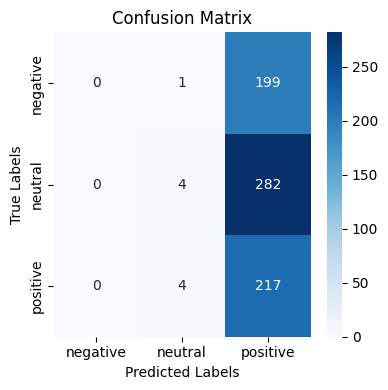

In [44]:
model.eval()

with torch.no_grad():
    batch_size = 10
    y_pred = []
    y_pred_prob = []

    for i in range(0, len(X_test), batch_size):
        X_batch = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).to(DEVICE)

        outputs = model(X_batch).squeeze()
        pred = torch.argmax(outputs, dim=1)

        y_pred_prob += [prob.to("cpu").numpy() for prob in outputs]

        y_pred = y_pred + pred.tolist()

print(f"f1-score (macro) = {f1_score(y_test, y_pred, average='macro')}")

try:
# Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()
except:
    print("Can not print confusion metric")

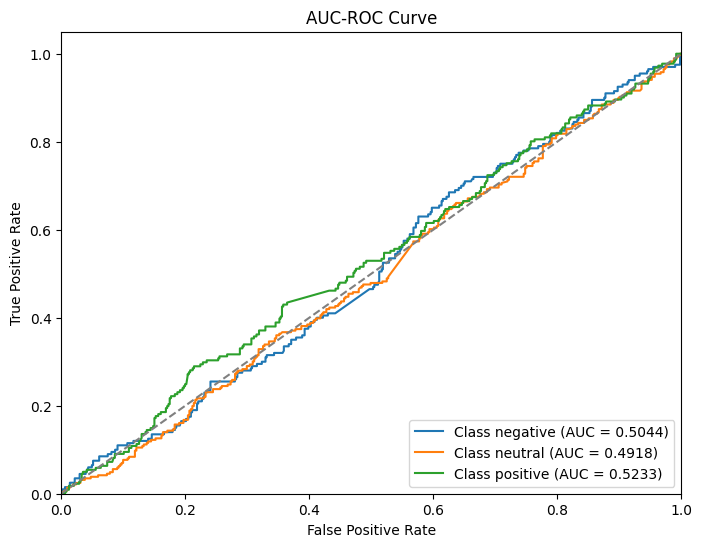

In [45]:
plot_roc_auc(y_test, np.array(y_pred_prob), le.classes_)